<a href="https://colab.research.google.com/github/qquantum/Data-Augmentation/blob/main/dataaugmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn 
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [ ]:
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(dataset_url,'.')

with tarfile.open('./cifar10.tgz','r:gz') as tar:
  tar.extractall(path = './data')

data_dir  = './data/cifar10'
print(os.listdir(data_dir))
classes = os.listdir(data_dir + '/train')
print(ChildProcessError)


['train', 'test']
<class 'ChildProcessError'>


In [ ]:
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
train_tfms = tt.Compose([tt.RandomCrop(32,padding=4,padding_mode='reflect'),
                          tt.RandomHorizontalFlip(),
                          tt.ColorJitter(brightness=0.1,saturation=0.1),
                          tt.ToTensor(),
                          tt.Normalize(*stats,inplace=True)])
valid_tfms = tt.Compose([tt.ToTensor(),tt.Normalize(*stats)])


In [ ]:
train_ds = ImageFolder(data_dir+'/train',train_tfms)
val_ds = ImageFolder(data_dir+'/test',valid_tfms)

In [ ]:
batch_size = 400

train_dl =DataLoader(train_ds,batch_size,shuffle=True,num_workers=3,pin_memory=True)
val_dl = DataLoader(val_ds,batch_size*2,num_workers=3,pin_memory=True)

In [ ]:
def denormalize(images,means,stds):
  means = torch.tensor(means).reshape(1,3,1,1)
  stds = torch.tensor(stds).reshape(1,3,1,1)
  return images*means+stds

def show_batch(dl):
  for images,labels  in dl:
    fig,ax = plt.subplots(figsize=(12,12))
    ax.set_xticks([]); ax.set_yticks([])
    denorm_images = denormalize(images,*stats)
    ax.imshow(make_grid(denorm_images[:64],nrow=8).permute(1,2,0).clamp(0,1))
    break

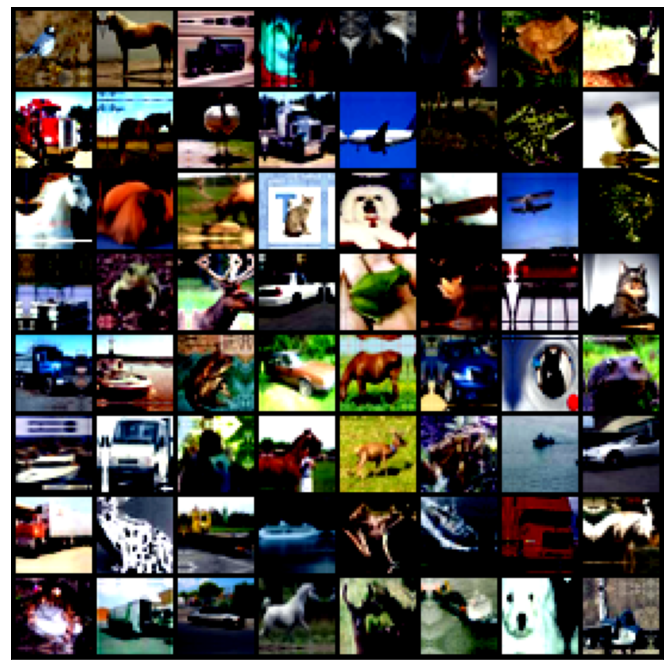

In [ ]:
show_batch(train_dl)

In [ ]:
def get_default_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torhc.device('cpu')

def to_device(data,device):
    if isinstance(data,(list,tuple)):
      return [to_device(x,device) for x in data]
    return data.to(device,non_blocking=True)

class DeviceDataLoader():
  """wrap a dataloader to move data to a device"""
  def __init__(self,dl,device):
    self.dl = dl
    self.device = device
  def __iter__(self):
    """yield a batch of  data after moving it to device"""
    for b in self.dl:
      yield to_device(b,self.device)
  def __len__(self):
    """number of batch"""
    return len(self.dl)
    

    

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl,device)
val_dl = DeviceDataLoader(val_dl,device)

In [ ]:
class BasicResidualBlok(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels=3,out_channels=3,stride=1,kernel_size=3,padding=1)
    self.relu1 = nn.ReLU()
    self.conv2 = nn.Conv2d(in_channels=3,out_channels=3,stride=1,kernel_size=3,padding=1)
    self.relu2 = nn.ReLU()

  def forward(self,x):
    out = self.conv1(x)
    out = self.relu1(out)
    out = self.conv2(out)
    return self.relu2(out) +x

In [ ]:
simple_resnet = to_device(BasicResidualBlok(),device)
for images,labels in train_dl:
  out = simple_resnet(images)
  print(out.shape)
  break

del simple_resnet,images,labels
torch.cuda.empty_cache()

torch.Size([400, 3, 32, 32])


In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
def conv_block(in_channels,out_channels,pool=False):
  layers = [nn.Conv2d(in_channels,out_channels,kernel_size=3,padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)]
  if pool:layers.append(nn.MaxPool2d(2))
  return nn.Sequential(*layers)

class Resnet9(ImageClassificationBase):
  def __init__(self,in_channels,num_classes):
    super().__init__()
     #3x32x32
    self.conv1 = conv_block(in_channels,64) #64x32x32
    self.conv2 = conv_block(64,128,pool=True) #128x16x16
    self.res1 = nn.Sequential(conv_block(128,128),
                              conv_block(128,128)) #128x16x16

    self.conv3 = conv_block(128,256,pool= True)  #256 x16x16
    self.conv4 = conv_block(256,512,pool=False)
    self.conv5 = conv_block(512,1024,pool=True)  #512x8x8
    self.res2 = nn.Sequential(conv_block(1024,1024),
                              conv_block(1024,1024))  #1024x4x4
    
    self.classifier = nn.Sequential(nn.MaxPool2d(4), #1024x1x1
                                    nn.Flatten(),  #1024
                                    nn.Dropout(0.2), #1024
                                    nn.Linear(1024,num_classes)) #10

  def forward(self,xb):
    out = self.conv1(xb)
    out = self.conv2(out)
    out = self.res1(out) +out
    out = self.conv3(out)
    out = self.conv4(out)
    out = self.conv5(out)
    out = self.res2(out) +out
    out = self.classifier(out)
    return out

In [ ]:
model = to_device(Resnet9(3, 10), device)
model

Resnet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history


In [ ]:
history = [evaluate(model,val_dl)]
history

Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f8ae05dc4a8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f8ae05dc4a8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel

[{'val_acc': 0.09711538255214691, 'val_loss': 2.293304204940796}]

In [ ]:
epochs = 20
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-3
opt_func = torch.optim.Adam

In [ ]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)


Epoch [0], last_lr: 0.00103, train_loss: 0.8024, val_loss: 1.1644, val_acc: 0.6289
Epoch [1], last_lr: 0.00279, train_loss: 0.7412, val_loss: 0.7091, val_acc: 0.7663
Epoch [2], last_lr: 0.00519, train_loss: 0.7582, val_loss: 0.8746, val_acc: 0.7079
Epoch [3], last_lr: 0.00759, train_loss: 0.7623, val_loss: 0.8993, val_acc: 0.6741
Epoch [4], last_lr: 0.00936, train_loss: 0.7368, val_loss: 1.5816, val_acc: 0.5098
Epoch [5], last_lr: 0.01000, train_loss: 0.7310, val_loss: 0.9897, val_acc: 0.6554
Epoch [6], last_lr: 0.00987, train_loss: 0.7103, val_loss: 1.0975, val_acc: 0.6195
Epoch [7], last_lr: 0.00950, train_loss: 0.7061, val_loss: 1.2702, val_acc: 0.5845
Epoch [8], last_lr: 0.00891, train_loss: 0.6886, val_loss: 1.3396, val_acc: 0.5791
Epoch [9], last_lr: 0.00812, train_loss: 0.6790, val_loss: 0.9759, val_acc: 0.6611
Epoch [10], last_lr: 0.00717, train_loss: 0.6456, val_loss: 1.2392, val_acc: 0.5978
Epoch [11], last_lr: 0.00611, train_loss: 0.6049, val_loss: 0.9777, val_acc: 0.6743
Ep

In [ ]:
def plot_accuracies(history):
  accuracies = [x['val_acc'] for x in history]
  plt.plot(accuracies,'-x')
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.title("accuracy vs no of epochs")

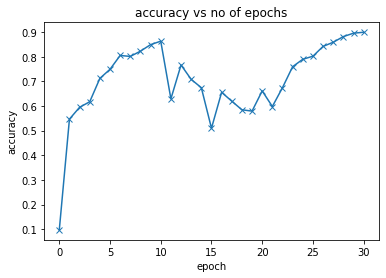

In [ ]:
plot_accuracies(history)

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');


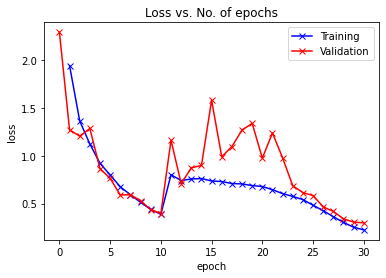

In [ ]:
plot_losses(history)

In [ ]:
def plot_lrs(history):
  lrs = np.concatenate([x.get('lrs',[]) for x in history])
  plt.plot(lrs)
  plt.xlabel('batch')
  plt.ylabel('lr')


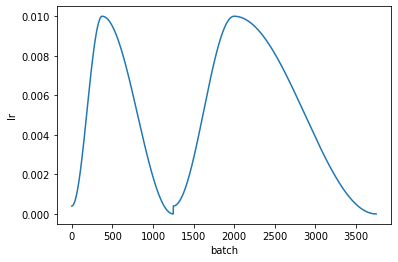

In [ ]:
plot_lrs(history)

In [ ]:
def predict_image(img,model):
  xb= to_device(img.unsqueeze(0),device)
  yb = model(xb)
  _,preds= torch.max(yb,dim=1)
  return train_ds.classes[preds[0].item()]

Label: airplane , Predicted: airplane


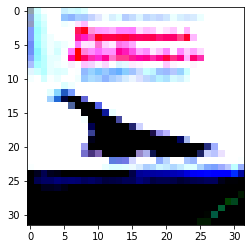

In [ ]:
img, label = val_ds[0]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

Label: airplane , Predicted: airplane


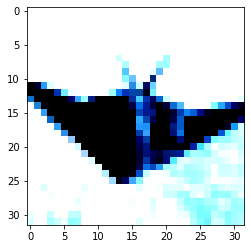

In [ ]:
img, label = val_ds[787]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

Label: cat , Predicted: cat


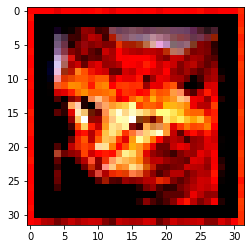

In [ ]:
img, label = val_ds[3431]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

Label: truck , Predicted: truck


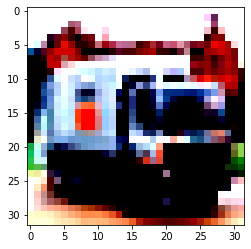

In [ ]:
img, label = val_ds[9000]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))